In [1]:
import pandas as pd
import numpy as np
import scipy.io 

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(LaCroixColoR)
    library(pals)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

In [3]:
ensemble_network_dir = "../data/networks/"
output_benchmark_path = "../data/representative_benchmark"

## What are the overall properties of the 1,000 simulated networks in the benchmark ensemble?

In [4]:
ensemble_summary_stats = (pd.read_csv("../data/Benchmark_ensemble_summary_stats.csv", 
                                     header=None, 
                                     names=['num_communities', 'num_overlapping_nodes', 
                                              'max_comm_size', 'min_comm_size'])
                                              .assign(network_index = lambda x: x.index + 1)
)

ensemble_summary_stats.head()

,num_communities,num_overlapping_nodes,max_comm_size,min_comm_size,network_index
0,9,27,59,14,1
1,8,20,62,15,2
2,6,27,72,16,3
3,8,22,59,16,4
4,9,18,59,13,5


## Let's view an example benchmark network

In [5]:
# We will analyze network 664
network_id = 664

example_benchmark_connectome = f"{ensemble_network_dir}/network{network_id}.dat"

network_edges_long = np.loadtxt(example_benchmark_connectome)
network_edges_long_df = (pd.DataFrame(network_edges_long, 
                                      columns=["source", "target", "weight"])
                        .assign(source=lambda x: x['source'].astype(int),
                                target=lambda x: x['target'].astype(int),
                                weight=lambda x: x['weight'].astype(float))
)

# Define OCDA results file for this network
network_ground_truth_comms = pd.read_csv(f"{output_benchmark_path}/Ground_Truth_Comms_Network{network_id}.csv", header=None)

In [6]:
import numpy as np

def node_sorter(bench_comms):
    """
    Sorts nodes according to community membership.

    Parameters
    ----------
    bench_comms : np.ndarray
        A binary (0/1) matrix of shape (n_nodes, n_communities) where
        bench_comms[i, j] == 1 means node i belongs to community j.

    Returns
    -------
    I : np.ndarray
        A 1D array of node indices sorted by community membership (each node appears once).
    """
    bench_comms = (bench_comms != 0).astype(int)  # Ensure binary matrix
    n_nodes = bench_comms.shape[0]
    I = np.zeros(n_nodes, dtype=int)

    counter = 0

    for i in range(bench_comms.shape[1]):  # Loop over communities
        members = np.where(bench_comms[:, i] == 1)[0]  # Node indices in this community
        I[counter:counter + len(members)] = members
        counter += len(members)
        bench_comms[members, :] = 0  # Zero out these nodes to avoid duplicates

    return I

In [7]:
sorted_node_order = node_sorter(network_ground_truth_comms.values)

In [8]:
(network_edges_long_df
 .head()
 .assign(source=lambda x: x['source'].astype(int),
            target=lambda x: x['target'].astype(int),
            weight=lambda x: x['weight'].astype(float))
 # Make source/
 )

,source,target,weight
0,1,12,0.855315
1,1,44,0.751024
2,1,67,0.848239
3,1,68,0.848330
4,1,71,0.848436


In [10]:
%%R -i network_edges_long_df,sorted_node_order 

network_edges_long_df %>% 
    mutate(source = factor(source, levels = sorted_node_order + 1),
              target = factor(target, levels = rev(sorted_node_order + 1)),
              weight = weight/max(weight, na.rm=T)) %>%
    arrange(source, target) %>%
    complete(source,target) %>%
    ggplot(data=., mapping=aes(x=source, y=target, fill=weight)) +
    # scale_fill_viridis_c(option='inferno', na.value='black') +
    scale_fill_gradientn(colors=pals::parula(100), na.value='black') +
    geom_raster() +
    labs(fill='') +
    guides(fill = guide_colourbar(frame.colour = "black", ticks.colour = "black")) +
    theme(legend.key.height = unit(3.25, "cm"),
            legend.key.width = unit(0.5, "cm"),
            axis.title = element_blank(),
          axis.ticks = element_blank(),
          axis.text = element_blank())
ggsave("../plots/benchmark_evaluation/Benchmark_representative_Network664_connectome.svg",
       width=6, height=5, units='in', dpi=300)

In [77]:
network_OSLOM10_results = pd.read_csv(f"{output_benchmark_path}/OSLOM_10_Result_Benchmark_Network{network_id}.csv", header=None)

# Find number of non-zero elements per row
num_communities_per_node = network_OSLOM10_results.apply(lambda x: np.count_nonzero(x), axis=1)
max_community_assigmnets = num_communities_per_node.max()

network_OSLOM10_results_long = (network_OSLOM10_results
                                .assign(node_index =lambda x: x.index + 1)
                                .melt(id_vars='node_index', 
                                      var_name='community_index', 
                                      value_name='membership')
                                .query("membership != 0")
)

network_OSLOM10_results_long.head()

,node_index,community_index,membership
3,4,0,1.0
17,18,0,0.5
22,23,0,1.0
29,30,0,1.0
39,40,0,1.0


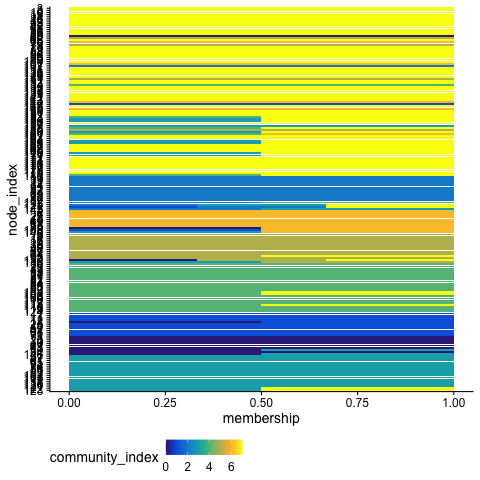

In [89]:
%%R -i network_OSLOM10_results_long,sorted_node_order

network_OSLOM10_results_long %>% 
    mutate(node_index = factor(node_index, levels = rev(sorted_node_order + 1))) %>%
    ggplot(data=., mapping=aes(x=node_index, y=membership, fill=community_index)) +
    geom_bar(stat='identity', position='stack') +
    coord_flip() +
    theme(legend.position='bottom') +
    scale_fill_gradientn(colors=pals::parula(100), na.value='black') 